# Callisto Test Generation for CIFAR-10


### Dependencies
* Python 3
* Keras
* Tensorflow==1.15.0
* Random
* Pickle
* Math
* Matplotlib
* OpenCV
* numpy


In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import _pickle as pickle

Using TensorFlow backend.


#### Please change 'MINI_DATASET_TEST' to False if you want to run the full CIFAR-10 dataset. Once it is set to true, the test generation framework will only run for a subset images in the interest of time. 

In [2]:
MINI_DATASET_TEST = True
MINI_DATASET_N = 1000

#### Please change 'VERBOSE' to False if you want to not print a lot of information

In [3]:
VERBOSE = True

In [4]:
# Training parameters
num_classes = 10

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if MINI_DATASET_TEST:
    x_train = x_train[:MINI_DATASET_N]
    x_test = x_test[:MINI_DATASET_N]
    y_train = y_train[:MINI_DATASET_N]
    y_test = y_test[:MINI_DATASET_N]

    
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (1000, 32, 32, 3)
1000 train samples
1000 test samples
y_train shape: (1000, 10)


In [5]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [7]:
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 6

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
    
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)    

In [8]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
if version == 2:
    model1 = resnet_v2(input_shape=input_shape, depth=depth)
    model2 = resnet_v2(input_shape=input_shape, depth=depth)    
else:
    model1 = resnet_v1(input_shape=input_shape, depth=depth)
    model2 = resnet_v1(input_shape=input_shape, depth=depth)

W1208 15:12:48.216056 4667456832 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W1208 15:12:51.001197 4667456832 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



### Please download the pre-trained CIFAR-10 model [here](https://drive.google.com/file/d/1wAxCv0hpV-_i5GUTsWr8WcgshKAdSupA/view?usp=sharing) and save it in the "models" folder if you download this file independently. If you have downloaded it as part of the GitHub repo, it should be downloaded automatically

### MD5 checksum = c13b9191239b2198d1a58a186652914d

In [10]:
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
print(model_type)

model1_file = "../models/CIFAR-10.h5py"

model1.load_weights(model1_file)

Learning rate:  0.001
ResNet56v2


In [11]:
test_loss, test_acc = model1.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

W1208 15:12:57.162341 4667456832 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



1000/1000 [==============================] - 7s 7ms/step
Test accuracy: 0.8579999804496765


### all_train_acts.pickle contains all the activations of the training data. This is necesscary for Callisto to calculate the shannon indices of the image input. Please download the file [here](https://drive.google.com/file/d/1PGVjDtV-vJJHz9QEjkIUpWPMNaTbGQpd/view?usp=sharing) if you download this file independently. The file should be saved in the "saved_pickles". 

### If you have downloaded it as part of the GitHub repo, it should be downloaded automatically

### MD5 Sum = bc8c6bc9a7517d9eb5de342db3e6e7f9

In [12]:
with open('../saved_pickles/all_train_acts.pickle', 'rb') as handle: 
     all_acts = pickle.load(handle)
        
if MINI_DATASET_TEST:
    all_acts = all_acts[:MINI_DATASET_N]

In [13]:
def shannon(arrs):
    shannons = []
    for arr in arrs:
        sum = 0
        for i in arr:
            sum += (i*np.log(i))
        shannons.append(sum * -1.0)
    return shannons

In [14]:
all_shannons = shannon(all_acts)

In [15]:
low_shannon_true = []
for i in range(len(all_shannons)):
    if all_shannons[i] < 0.001 and np.argmax(all_acts[i]) == np.argmax(y_train[i]) : 
        low_shannon_true.append(i)
        
print("low_shannon_true:", len(low_shannon_true))

low_shannon_true: 777


In [16]:
rows,cols = (32, 32)
M = np.float32([[1,0,2],[0,1,2]])

Original Image


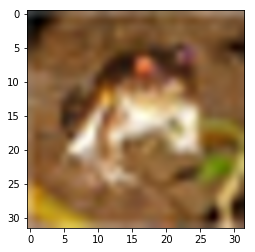

In [17]:
print("Original Image")
img = x_train[0]
label = y_train[0]
plt.imshow(img, cmap=plt.cm.binary, interpolation = 'spline16')
plt.show()

Transformation: Panning


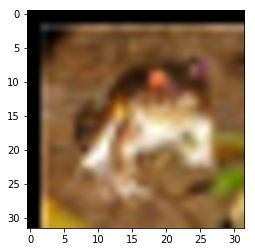

In [18]:
print("Transformation: Panning")
M = np.float32([[1,0,2],[0,1,2]])
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary, interpolation = 'spline16')
plt.show()

In [19]:
print("Transformation: Panning")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = model1.predict(img)[0]
    
    dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,3)
    dst = (np.expand_dims(dst,0))
    dst_pred = model1.predict(dst)[0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Panning
Shannon Treshold : < 0.001
Number of inputs:  777
Error Rate:  0.10682110682110682


In [20]:
print("Transformation: Panning")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    if VERBOSE:
            print("Shannon Treshold : >", threshold)
            print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = model1.predict(img)[0]

            dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,3)
            dst = (np.expand_dims(dst,0))
            dst_pred = model1.predict(dst)[0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1
                
        if VERBOSE:       
            print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
            

        if not VERBOSE:
            print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
    else:
        print("There are no inputs above threshold: ", threshold)
    
    print("")

Transformation: Panning
Shannon Treshold : > 0.01
Number of inputs:  96
Error Rates : 0.2708333333333333

Shannon Treshold : > 0.025
Number of inputs:  68
Error Rates : 0.3235294117647059

Shannon Treshold : > 0.05
Number of inputs:  44
Error Rates : 0.29545454545454547

Shannon Treshold : > 0.1
Number of inputs:  23
Error Rates : 0.2608695652173913

Shannon Treshold : > 0.2
Number of inputs:  12
Error Rates : 0.25

Shannon Treshold : > 0.3
Number of inputs:  7
Error Rates : 0.2857142857142857

Shannon Treshold : > 0.4
Number of inputs:  6
Error Rates : 0.3333333333333333

Shannon Treshold : > 0.5
Number of inputs:  4
Error Rates : 0.5

Shannon Treshold : > 0.6
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.7
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.8
Number of inputs:  1
Error Rates : 0.0

Shannon Treshold : > 0.9
Number of inputs:  0
There are no inputs above threshold:  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
There are no inputs above

Transformation: 2D rotation


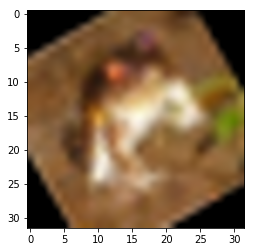

In [21]:
print("Transformation: 2D rotation")
M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary, interpolation = 'spline16')
plt.show()

In [22]:
print("Transformation: 2D rotation")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = model1.predict(img)[0]
    
    dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,3)
    dst = (np.expand_dims(dst,0))
    dst_pred = model1.predict(dst)[0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: 2D rotation
Shannon Treshold : < 0.001
Number of inputs:  777
Error Rate:  0.5637065637065637


In [23]:
print("Transformation: 2D rotation")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    if VERBOSE:
            print("Shannon Treshold : >", threshold)
            print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = model1.predict(img)[0]

            dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,3)
            dst = (np.expand_dims(dst,0))
            dst_pred = model1.predict(dst)[0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1
                
        if VERBOSE:       
            print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
            

        if not VERBOSE:
            print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
    else:
        print("There are no inputs above threshold: ", threshold)
    
    print("")

Transformation: 2D rotation
Shannon Treshold : > 0.01
Number of inputs:  96
Error Rates : 0.625

Shannon Treshold : > 0.025
Number of inputs:  68
Error Rates : 0.6176470588235294

Shannon Treshold : > 0.05
Number of inputs:  44
Error Rates : 0.6136363636363636

Shannon Treshold : > 0.1
Number of inputs:  23
Error Rates : 0.6521739130434783

Shannon Treshold : > 0.2
Number of inputs:  12
Error Rates : 0.4166666666666667

Shannon Treshold : > 0.3
Number of inputs:  7
Error Rates : 0.2857142857142857

Shannon Treshold : > 0.4
Number of inputs:  6
Error Rates : 0.16666666666666666

Shannon Treshold : > 0.5
Number of inputs:  4
Error Rates : 0.25

Shannon Treshold : > 0.6
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.7
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.8
Number of inputs:  1
Error Rates : 0.0

Shannon Treshold : > 0.9
Number of inputs:  0
There are no inputs above threshold:  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
There are no inputs

Transformation: Affine


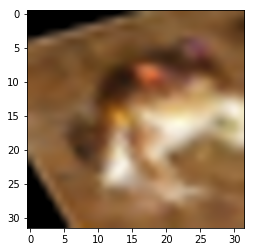

In [24]:
print("Transformation: Affine")
pts1 = np.float32([[5,5],[20,5],[5,20]])
pts2 = np.float32([[1,10],[20,5],[10,25]])
M = cv2.getAffineTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary, interpolation = 'spline16')
plt.show()

In [25]:
print("Transformation: Affine")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = model1.predict(img)[0]
    
    dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,3)
    dst = (np.expand_dims(dst,0))
    dst_pred = model1.predict(dst)[0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Affine
Shannon Treshold : < 0.001
Number of inputs:  777
Error Rate:  0.5328185328185329


In [26]:
print("Transformation: Affine")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    if VERBOSE:
            print("Shannon Treshold : >", threshold)
            print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = model1.predict(img)[0]

            dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,3)
            dst = (np.expand_dims(dst,0))
            dst_pred = model1.predict(dst)[0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1
                
        if VERBOSE:       
            print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
            

        if not VERBOSE:
            print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
    else:
        print("There are no inputs above threshold: ", threshold)
    
    print("")

Transformation: Affine
Shannon Treshold : > 0.01
Number of inputs:  96
Error Rates : 0.5729166666666666

Shannon Treshold : > 0.025
Number of inputs:  68
Error Rates : 0.5588235294117647

Shannon Treshold : > 0.05
Number of inputs:  44
Error Rates : 0.5454545454545454

Shannon Treshold : > 0.1
Number of inputs:  23
Error Rates : 0.5652173913043478

Shannon Treshold : > 0.2
Number of inputs:  12
Error Rates : 0.3333333333333333

Shannon Treshold : > 0.3
Number of inputs:  7
Error Rates : 0.2857142857142857

Shannon Treshold : > 0.4
Number of inputs:  6
Error Rates : 0.16666666666666666

Shannon Treshold : > 0.5
Number of inputs:  4
Error Rates : 0.25

Shannon Treshold : > 0.6
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.7
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.8
Number of inputs:  1
Error Rates : 0.0

Shannon Treshold : > 0.9
Number of inputs:  0
There are no inputs above threshold:  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
There are n

Transformation: Perspective


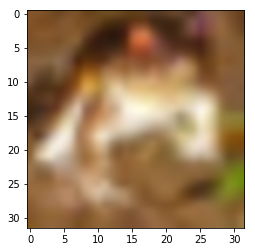

In [27]:
print("Transformation: Perspective")
pts1 = np.float32([[5,5],[28,5],[5,28],[28,28]])
pts2 = np.float32([[0,0],[32,0],[0,32],[32,32]])
M = cv2.getPerspectiveTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpPerspective(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary, interpolation = 'spline16')
plt.show()

In [28]:
print("Transformation: Perspective")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = model1.predict(img)[0]
    
    dst = cv2.warpPerspective(x_train[i],M,(32,32)).reshape(32,32,3)
    dst = (np.expand_dims(dst,0))
    dst_pred = model1.predict(dst)[0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Perspective
Shannon Treshold : < 0.001
Number of inputs:  777
Error Rate:  0.25868725868725867


In [29]:
print("Transformation: Perspective")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    if VERBOSE:
            print("Shannon Treshold : >", threshold)
            print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = model1.predict(img)[0]

            dst = cv2.warpPerspective(x_train[i],M,(32,32)).reshape(32,32,3)
            dst = (np.expand_dims(dst,0))
            dst_pred = model1.predict(dst)[0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1
                
        if VERBOSE:       
            print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
            

        if not VERBOSE:
            print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
    else:
        print("There are no inputs above threshold: ", threshold)
    
    print("")

Transformation: Perspective
Shannon Treshold : > 0.01
Number of inputs:  96
Error Rates : 0.4166666666666667

Shannon Treshold : > 0.025
Number of inputs:  68
Error Rates : 0.47058823529411764

Shannon Treshold : > 0.05
Number of inputs:  44
Error Rates : 0.45454545454545453

Shannon Treshold : > 0.1
Number of inputs:  23
Error Rates : 0.391304347826087

Shannon Treshold : > 0.2
Number of inputs:  12
Error Rates : 0.4166666666666667

Shannon Treshold : > 0.3
Number of inputs:  7
Error Rates : 0.5714285714285714

Shannon Treshold : > 0.4
Number of inputs:  6
Error Rates : 0.5

Shannon Treshold : > 0.5
Number of inputs:  4
Error Rates : 0.5

Shannon Treshold : > 0.6
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.7
Number of inputs:  2
Error Rates : 0.0

Shannon Treshold : > 0.8
Number of inputs:  1
Error Rates : 0.0

Shannon Treshold : > 0.9
Number of inputs:  0
There are no inputs above threshold:  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
There are no inputs ab